In [1]:
import numpy as np
import matplotlib.pylab as plt
import copy
import cmath
# add angler to path (not necessary if pip installed)
import sys
sys.path.append("..")

# import the main simulation and optimization classes
from angler import Simulation, Optimization

# import some structure generators
from angler.structures import three_port, two_port, N_port

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
lambda0 = 1.55e-6        
c0 = 3e8           
omega = 2*np.pi*c0/lambda0
dl = 0.5e-1
NPML = [20, 20]
pol = 'Ez'
source_amp = 1e-9 

n_index = 3.475 
eps_m = 11.70 

N = 2
L = 6
H = 6
w = 0.4 #um
d = 2  
l = 6
spc = 3


#Mi4 = np.array([0.555+0.243j,-0.116+0.913j,0.785-0.295j,-0.675-0.229j])
#Mi4 = np.array([0.555+0.243j,0.116+0.913j,0.785+0.295j,0.675+0.229j])
#Mi4 =np.array([0.2,0.1,0.5,0.2])

#Mi4 =np.array([0.2,0.8])
Mi4 =np.array([0.2+0.2j,0.8-0.8j])
#Mi4p = np.zeros(N,dtype = "complex128")
Mi4p = np.zeros(N)
for i in range(N):
    Mi4p[i] = np.abs(Mi4[i])
MSUM = np.sum(Mi4p)
print(MSUM)
print((Mi4 / MSUM))

1.4142135623730954
[0.14142136+0.14142136j 0.56568542-0.56568542j]


Computed a domain with 400 grids in x and 280 grids in y
The simulation has 30 grids per free space wavelength


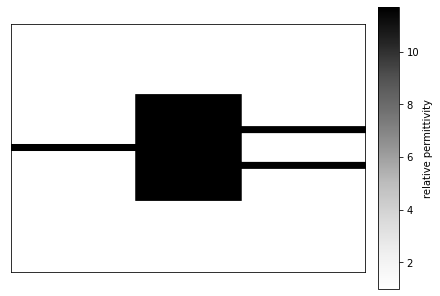

In [3]:
eps_r, design_region = N_port(N, L, H, w, d, l, spc, dl, NPML, eps_m)
(Nx, Ny) = eps_r.shape
nx, ny = int(Nx/2), int(Ny/2)

simulation1 = Simulation(omega, eps_r, dl, NPML, pol)

print("Computed a domain with {} grids in x and {} grids in y".format(Nx,Ny))
print("The simulation has {} grids per free space wavelength".format(int(lambda0/dl/simulation1.L0)))

simulation1.plt_eps(outline=False)
plt.show()

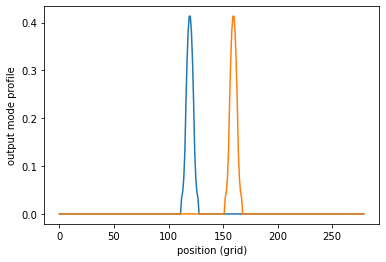

In [4]:
simulation1.add_mode(neff=n_index, direction_normal='x', center=[NPML[0]+int(l/2/dl), ny], width=int(H/2/dl), scale= 1 *source_amp)
simulation1.setup_modes()
#W_in = simulation1.W_in
#print(W_in)

J_list1 = []

for i in range(N):
    sim_tmp1 = Simulation(omega, eps_r, dl, NPML, 'Ez')
    y1 = (float(i)-float(N-1)/2.0)*d
    y_index1 = int(y1/dl + ny)
    sim_tmp1.add_mode(neff=n_index, direction_normal='x', center=[-NPML[0]-int(l/2/dl), y_index1], width=int(2*w/dl))
    sim_tmp1.setup_modes()
    J_tmp1 = np.abs(sim_tmp1.src)
    J_list1.append(J_tmp1)
    plt.plot(J_tmp1[-NPML[0]-int(l/2/dl), :])
plt.xlabel('position (grid)')
plt.ylabel('output mode profile')
plt.show()

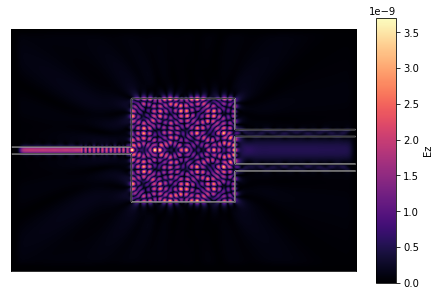

In [5]:
(Hx, Hy, Ez) = simulation1.solve_fields()
simulation1.plt_abs(outline=True, cbar=True);

computed a scale of (-9.629692856170677e-10+3.02059066463775e-09j)


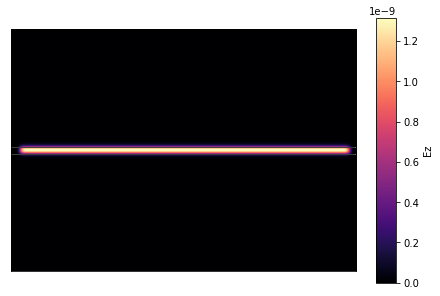

In [6]:
eps_r_wg, _ = two_port(L, H, w, l, spc, dl, NPML, eps_start=eps_m)
(Nx_wg, Ny_wg) = eps_r_wg.shape
nx_wg, ny_wg = int(Nx_wg/2), int(Ny_wg/2)            # halfway grid points     
simulation_wg = Simulation(omega, eps_r_wg, dl, NPML, 'Ez')
simulation_wg.add_mode(n_index, 'x', [NPML[0]+int(l/2/dl), ny_wg], int(Ny/3), scale=source_amp)
simulation_wg.setup_modes()

# compute normalization
sim_out = Simulation(omega, eps_r_wg, dl, NPML, 'Ez')
sim_out.add_mode(n_index, 'x', [-NPML[0]-int(l/2/dl), ny], int(Ny/3))
sim_out.setup_modes()
J_out = np.abs(sim_out.src)
(_, _, Ez_wg) = simulation_wg.solve_fields()
#SCALE = np.sum(np.square(np.abs(Ez_wg*J_out)))
SCALE = np.sum(Ez_wg*J_out)
J_out = J_out
print('computed a scale of {}'.format(SCALE))

simulation_wg.plt_abs(outline=True, cbar=True);

for i in range(N):
    J_list1[i] = J_list1[i] / np.abs(SCALE)
#    J_list1[i] /= np.sqrt(SCALE)

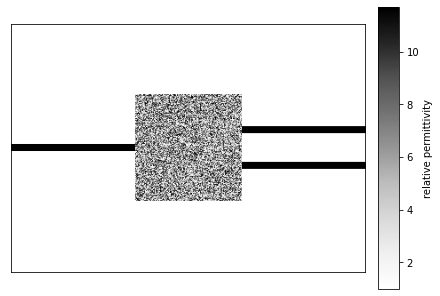

In [7]:
simulation1.init_design_region(design_region, eps_m, style='random')
simulation1.plt_eps(outline=False)
plt.show()

In [8]:
import autograd.numpy as npa
from angler.objective import Objective, obj_arg

arg1 = obj_arg('ez', component='Ez', nl=False)

def J(ez):
    ERRSUM = 0
    for i in range(N):
#        transmit_i = npa.sum(npa.square(npa.abs(ez*J_list1[i])))
#        ERRSUM += np.square(transmit_i - (Mi4[i] / MSUM) )
        transmit_i = npa.sum(ez*J_list1[i])
        ERRSUM += np.abs(transmit_i - (Mi4[i] / MSUM) ) 
    objfn = 1 - ERRSUM
    return objfn
        
objective = Objective(J, arg_list=[arg1])

'''#比例形式
def J(ez):
    ERRSUM = 0
    sumtransmit_i = 0
    for i in range(N):
#        transmit_i = npa.sum(npa.square(npa.abs(ez*J_list1[i])))
#        ERRSUM += np.square(transmit_i - (Mi4[i] / MSUM) )
        transmit_i = np.sum(np.abs(ez*J_list1[i]))
        sumtransmit_i +=transmit_i
        
    for i in range(N):    
        transmit_i = np.sum(ez*J_list1[i])
        ERRSUM += np.abs((transmit_i/sumtransmit_i - (Mi4[i] / MSUM)) ) 
    objfn = 1 - ERRSUM
    return objfn'''
        
objective = Objective(J, arg_list=[arg1])

In [9]:
R = 5
beta = 500  
eta = 0.50    

optimization = Optimization(objective=objective, simulation=simulation1, design_region=design_region, eps_m=eps_m, R=R, beta=beta, eta=eta)

 99% (347 of 349) |##################### | Elapsed Time: 0:01:24 ETA:   0:00:00

In [10]:
(grad_avm, grad_num) = optimization.check_deriv(Npts=5, d_rho=5e-4)
print('adjoint gradient   = {}\nnumerical gradient = {}'.format(grad_avm, grad_num))

adjoint gradient   = [-0.023420844374251952, -0.00683542462048411, -0.19796005984898937, -0.002866261640223356, -0.015053506047408233]
numerical gradient = [-0.02337297469878763, -0.006824620000234205, -0.1980426117276224, -0.0028546816595032, -0.015063135021975427]


In [11]:
new_eps = optimization.run(method='lbfgs', Nsteps=800)

 ObjectiveFn:  0.987 Iteration:  772/800 ETA:   0:10:23                        

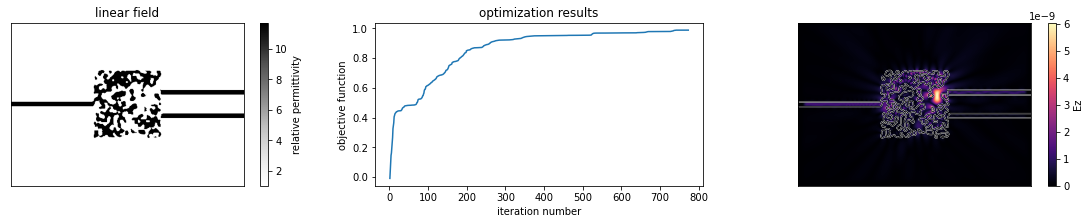

In [12]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,3))

simulation1.plt_eps(ax=ax1, outline=False)
ax1.set_title('final permittivity distribution')

optimization.plt_objs(ax=ax2)
ax2.set_yscale('linear')

(_,_,Ez) = simulation1.solve_fields()
simulation1.plt_abs(ax=ax3, vmax=None)
ax1.set_title('linear field')

plt.show()

In [13]:
# plot transmission characteristics

(_, _, ez) = simulation1.solve_fields()

OUTPUT = np.zeros(N,dtype="complex128")
OUTPUT_MSUM = np.zeros(N,dtype="complex128")
for i in range(N):
    OUTPUT[i] = npa.sum(ez*J_list1[i])
#    OUTPUT[i] =npa.sum(npa.square(npa.abs(ez*J_list1[i])))
print('OUTPUT:','\n',OUTPUT)
print('\n')

for j in range(N):
    OUTPUT_MSUM[j] = OUTPUT[j] * MSUM
print('通过结构优化的输出复数值OUTPUT_MSUM:','\n',OUTPUT_MSUM)
print('\n')

print('期望分光复数值M:','\n',Mi4)


OUTPUT: 
 [0.14142133+0.14142142j 0.55696693-0.55654772j]


通过结构优化的输出复数值OUTPUT_MSUM: 
 [0.19999996+0.20000009j 0.78767018-0.78707734j]


期望分光复数值M: 
 [0.2+0.2j 0.8-0.8j]


Text(0.5, 1.0, 'final permittivity distribution')

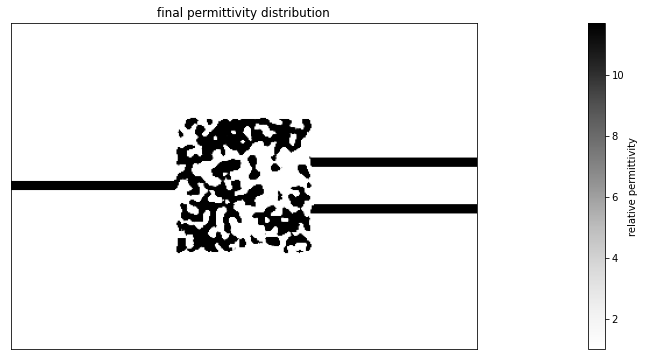

In [14]:
f, (ax1) = plt.subplots(1, 1, figsize=(40,6))

simulation1.plt_eps(ax=ax1, outline=False)
ax1.set_title('final permittivity distribution')

Text(0.5, 1.0, 'linear field')

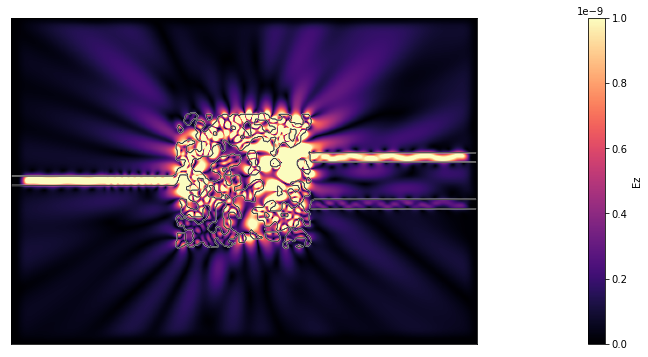

In [15]:
f, (ax3) = plt.subplots(1, 1, figsize=(40,6))
(_,_,Ez) = simulation1.solve_fields()
simulation1.plt_abs(ax=ax3, vmax=1e-9)
ax1.set_title('linear field')